In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import getpass

user = getpass.getuser()

from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt

/home/nsharma/miniconda3/envs/risingverse/lib/python3.7/site-packages/xarray/core/merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [7]:
# change file name here for RCP8.5
ce = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons_new_mc/SSP3/damages_ce.csv") 
mc = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons_new_mc/SSP3/damages_nocons.csv")
ce = ce[["discrate","year","pulse","rcp","damages", "variable"]]
mc = mc[["discrate","year","pulse","rcp","damages", "variable"]]
ce = ce[(ce.rcp == "rcp45")]
mc = mc[(mc.rcp == "rcp45")]

In [8]:
damages = pd.merge(ce, mc, on= ['discrate', 'year', 'pulse', 'rcp'], how = 'inner')
damages['diff_damages'] = damages.damages_x - damages.damages_y
# damages

In [9]:
damages.groupby('discrate')['diff_damages'].describe()

,count,mean,std,min,25%,50%,75%,max
discrate,,,,,,,,
1.0,281.0,0.000724,0.000318,-0.000039,4.542573e-04,0.000745,0.001049,0.001098
2.0,281.0,0.000183,0.000105,-0.000018,1.085335e-04,0.000164,0.000193,0.000417
2.5,281.0,0.000116,0.000105,-0.000012,4.027642e-05,0.000076,0.000118,0.000334
3.0,281.0,0.000082,0.000097,-0.000008,1.536066e-05,0.000040,0.000088,0.000282
5.0,281.0,0.000036,0.000065,-0.000002,2.624188e-07,0.000003,0.000024,0.000232


In [10]:
damages = pd.merge(ce, mc, on= ['discrate', 'year', 'pulse', 'rcp'], how = 'inner')
damages['diff_damages'] = damages.damages_x - damages.damages_y
# damages

In [11]:
# generating a list of years where diff damages is negative
years_low = damages.loc[damages.diff_damages < 0].year.unique()
years_low

array([2098., 2099., 2100.])

In [7]:
# reading the coeffs in ce and mc to obtain damage functions

ce_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SSP3/ce_betas_SSP3.csv")
ce_coeffs = ce_coeffs[["year", "cons","beta1","beta2"]]

mc_coeffs = pd.read_csv("/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/SSP3/nocons_betas_SSP3.csv")
mc_coeffs = mc_coeffs[["year", "cons","beta1","beta2"]]

In [8]:
# ANALYSIS FOR RCP4.5

coeffs = pd.merge(ce_coeffs, mc_coeffs, on= ['year'], how = 'inner') 
# coeffs = coeffs[coeffs['year'].isin(years_low)] # uncomment if comparison wanted only for years where ce damages < regular damages

fair = pd.read_csv("/mnt/CIL_labor/6_ce/ce_cons_nocons_diagnostics/rcp85_anomalies.csv")

df = pd.merge(coeffs, fair, on= ['year'], how = 'inner')

# generate CE variables: damages due to pulse and level at rcp anomaly 
df['pulse_df_ce'] = (df.cons_x + df.fair_temperatures_anomaly_pulse * df.beta1_x + df.fair_temperatures_anomaly_pulse**2 * df.beta2_x)
df['level_ce'] = (df.cons_x + df.fair_temperatures_anomaly_rcp * df.beta1_x + df.fair_temperatures_anomaly_rcp**2 * df.beta2_x)
df['ce_damages'] = df.pulse_df_ce - df.level_ce

# generate non-CE variables: damages due to pulse and level at rcp anomaly 
df['pulse_df_mc'] = (df.cons_y + df.fair_temperatures_anomaly_pulse * df.beta1_y + df.fair_temperatures_anomaly_pulse**2 * df.beta2_y)
df['level_reg'] = (df.cons_y + df.fair_temperatures_anomaly_rcp * df.beta1_y + df.fair_temperatures_anomaly_rcp**2 * df.beta2_y)
df['reg_damages'] = df.pulse_df_mc - df.level_reg

# diff between CE and non-CE damages
df['diff'] = df.ce_damages - df.reg_damages

# slope = beta1 + 2*beta2*fair_anomaly for each case for rcp anomaly
df['slope_ce'] = (df.beta1_x + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_x)
df['slope_reg'] = (df.beta1_y + 2 * df.fair_temperatures_anomaly_rcp * df.beta2_y)

# final df
df[['year', 'ce_damages', 'reg_damages', 'fair_temperatures_anomaly_rcp', 'diff', 'level_ce', 'level_reg', 'slope_ce', 'slope_reg']]#.to_csv('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/rcp45_df.csv')

# dff[dff['year'].isin(years_low)]


,year,ce_damages,reg_damages,fair_temperatures_anomaly_rcp,diff,level_ce,level_reg,slope_ce,slope_reg
0,2018,0.000000e+00,0.000000e+00,0.231451,0.000000e+00,0.010851,0.010497,-0.002631,-0.003668
1,2019,0.000000e+00,0.000000e+00,0.251202,0.000000e+00,0.011512,0.011142,-0.006904,-0.007923
2,2020,-2.523102e-07,-8.433663e-07,0.273559,5.910561e-07,0.015447,0.015051,-0.000304,-0.001303
3,2021,2.739882e-05,2.645143e-05,0.302285,9.473888e-07,0.019180,0.018756,0.028273,0.027298
4,2022,3.112400e-05,2.998725e-05,0.336390,1.136751e-06,0.028888,0.028425,0.025735,0.024801
...,...,...,...,...,...,...,...,...,...
278,2296,7.990363e-03,7.863556e-03,7.293626,1.268074e-04,40.044395,39.552234,10.651866,10.482823
279,2297,8.041677e-03,7.913995e-03,7.308372,1.276814e-04,40.380676,39.883817,10.720273,10.550064
280,2298,8.086345e-03,7.957900e-03,7.321670,1.284447e-04,40.703851,40.202502,10.787011,10.615670
281,2299,8.127143e-03,7.998013e-03,7.331162,1.291305e-04,40.988064,40.482852,10.848673,10.676302


In [9]:
len(df.loc[df.level_ce < df.level_reg].year.unique())
df.loc[df.level_ce < df.level_reg].year.unique()

array([], dtype=int64)

In [10]:
# generating df of anomalies between -5 to 20 in 1101 steps for each year between 2015 to 2100
temp_range = np.linspace(0.25, 4.25, 17)
idx = product(range(2015,2301), temp_range) 
temps = np.stack([temp_range for _ in range(2015,2301)]).flatten() 
temps = pd.DataFrame(temps, index=[i for i,x in idx], columns=['temp'])
temps = temps.reset_index().rename(columns={"index":"year"})
# temps # checking things out

In [11]:
# certainty equivalence damage function
ce_df = pd.merge(ce_coeffs, temps, on= ['year'], how = 'inner') 
ce_df['ce_df_T'] = (ce_df.cons + ce_df.temp * ce_df.beta1 + ce_df.temp**2 * ce_df.beta2)
# ce_df # checking things out

# non-CE cloud labor mc damage function
mc_df = pd.merge(mc_coeffs, temps, on= ['year'], how = 'inner')
mc_df['mc_df_T'] = (mc_df.cons + mc_df.temp * mc_df.beta1 + mc_df.temp**2 * mc_df.beta2)
# mc_sm_df # checking things out

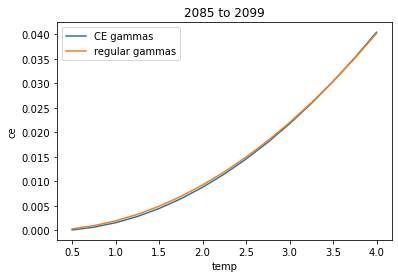

In [12]:
# rate of change of regular vs ce damages under RCP4.5

t = temps.loc[temps.year==2015]
t = t[t['temp'].between(0.48, 4.12)]
t['ce'] = -.0013502 * t.temp + .0028658 * t.temp**2
t['reg'] = -.0008155 * t.temp + .002716 * t.temp**2
t = t[['temp', 'ce', 'reg']]

# reg_values = pd.read_csv("/mnt/CIL_labor/6_ce/reg_values.csv")
# reg_values[reg_values['year'].between(2085,2099)].groupby('rcp')['temp'].describe()

sns.lineplot(data=t, x='temp', y='ce', label="CE gammas").set_title("2085 to 2099")
sns.lineplot(data=t, x='temp', y='reg', label="regular gammas")
plt.legend()
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/rate_of_change.pdf', format='pdf')


In [13]:
# overlaid grid plot of all years where ce_df_T < mc_df_T as per the SCC calculation

# comparison of smooth anomalies: CE, non-CE cloud, and non-CE mean 
df1 = pd.merge(ce_df, mc_df, on = ['year', 'temp'], how = 'outer')
df1 = df1[df1['year'].isin(years_low)]
# df1.to_csv('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/dfs_low_years.csv')

# generating years from 2020 to 2100 at every ten years
years = list(range(2020, 2301, 10))

# comparison of non-CE cloud smooth vs non-smooth anomalies
df2 = pd.merge(ce_df, mc_df, on = ['year', 'temp'], how = 'outer')
df2 = df2[df2['year'].isin(years)]



In [15]:
# # grid plot of non-CE vs CE in years where discounted ce damages < non-ce damages under RCP4.5 
# g = sns.FacetGrid(df1, col="year", col_wrap=7, sharey=True)
# g.map_dataframe(sns.lineplot, x='temp', y='ce_df_T', color = "blue", label="CE damage function").map_dataframe(sns.lineplot, x='temp', y='mc_df_T', color = "red", label="non-CE damage function")
# lgd = plt.legend(bbox_to_anchor=(0,1.5), ncol=2)
# # plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damage_func_comparison.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

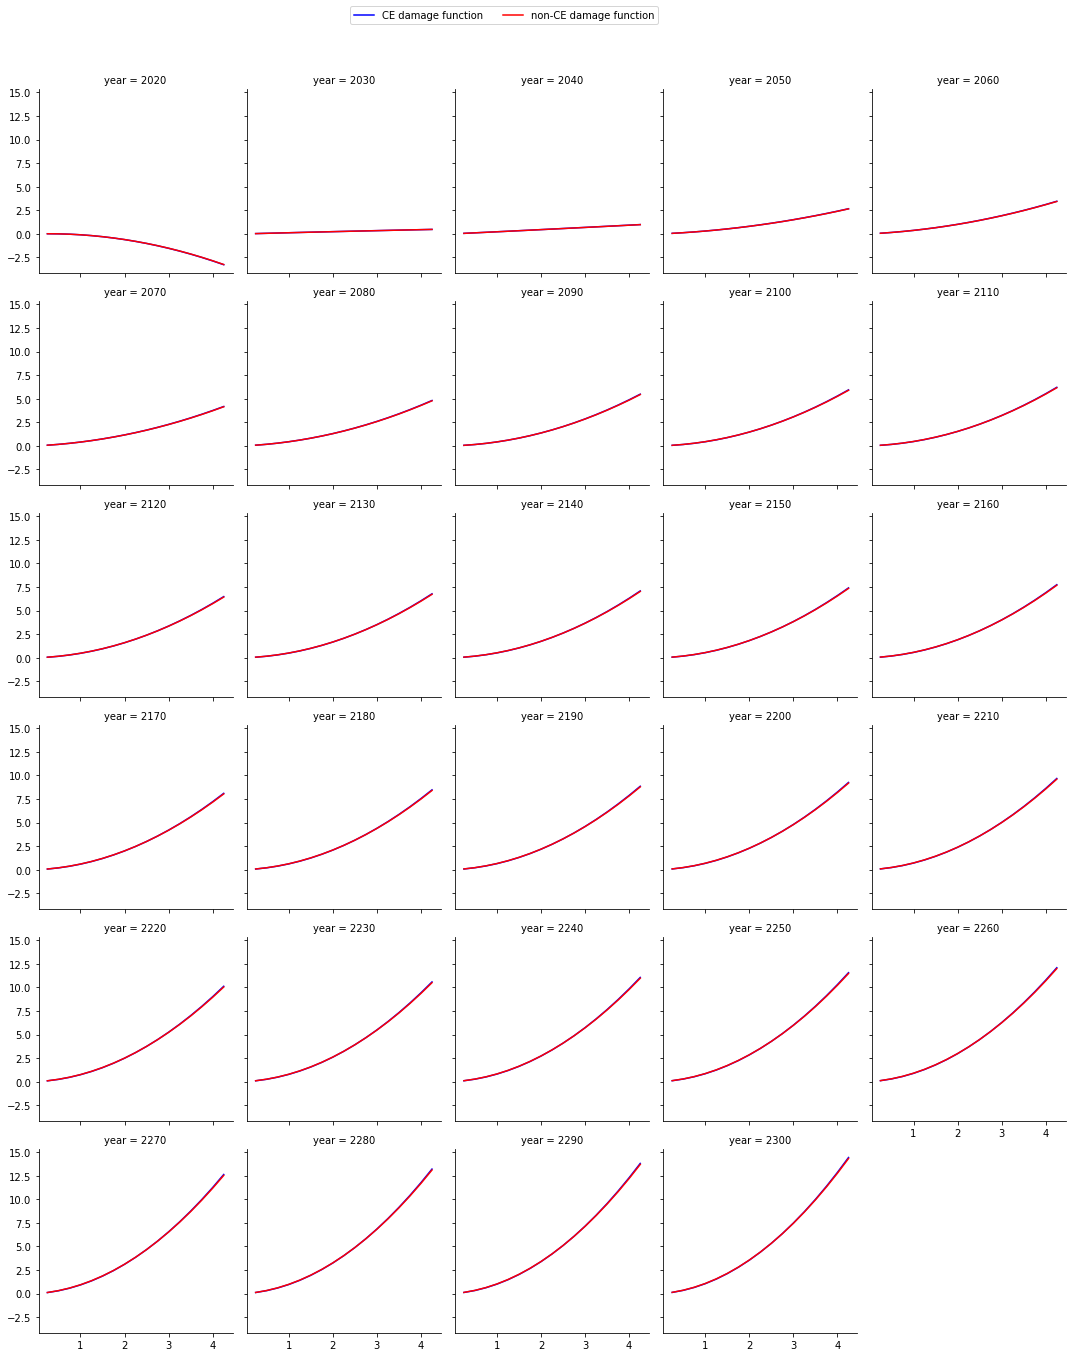

In [16]:
# making the grid plot of non-CE cloud smooth vs non-smooth anomalies
g = sns.FacetGrid(df2, col="year", col_wrap=5, sharey=True)
g.map_dataframe(sns.lineplot, x='temp', y='ce_df_T', color = "blue", label="CE damage function").map_dataframe(sns.lineplot, x='temp', y='mc_df_T', color = "red", label="non-CE damage function")
lgd = plt.legend(bbox_to_anchor=(0,7.25), ncol=2)
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/damage_function_no_cons/damage_all_years.pdf', format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

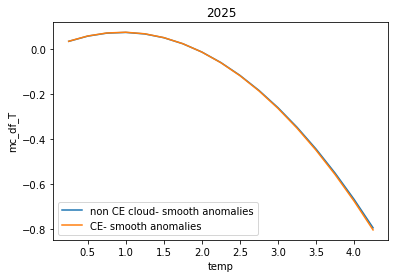

In [17]:
# trying the plot before the grid plot of DFs with smooth anomalies
sns.lineplot(data=mc_df.loc[mc_df.year == 2025], x='temp', y='mc_df_T', label="non CE cloud- smooth anomalies").set_title(2025)
sns.lineplot(data=ce_df.loc[ce_df.year == 2025], x='temp', y='ce_df_T', label="CE- smooth anomalies")
plt.legend()
# plt.savefig('/home/nsharma/repos/labor-code-release-2020/output/ce/damage_function_comparison/CE_vs_non_CE_smooth_anomalies_2025.pdf', format='pdf')